Set up:

In [2]:
%load_ext sql


In [3]:
%sql postgresql://appdev@data/appdev


'Connected: appdev@appdev'

In [7]:
%matplotlib inline

## Assignment 8: Spatial data and Magic: The gathering

*Deadline: 10th of April 12:00*

*Review deadline: 11th of April 23:59*

This assignment is split into two parts: a spatial part and a JSON parsing part

### 1. In the first part you'll be processing the data in the geonames table.

##### A. Find the tuple with the largest population

Two ways to select max. 

Created point type as max_point

In [31]:
%sql SELECT * FROM geonames WHERE population IN (SELECT MAX(population) FROM geonames);

1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut


In [30]:
%%sql 
DROP VIEW IF EXISTS maximum_population_geonames;
CREATE VIEW maximum_population_geonames AS SELECT *, point(longitude,latitude) as max_point FROM  geonames order by population DESC LIMIT 1;
SELECT * FROM maximum_population_geonames;

Done.
Done.
1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone,max_point
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut,"(36,34)"


##### B. Now calculate the distance from all locations to the tuple above using the <-> function

I put an intentional limit to 10. See full results in the end.

In [34]:
%sql SELECT name, longitude, latitude, point(latitude, longitude) <-> (SELECT max_point FROM maximum_population_geonames) as distance FROM  geonames order by distance LIMIT 10;

10 rows affected.


name,longitude,latitude,distance
Mazi İni,33.88903,36.46384,0.476929645230822
Ágios Geórgios Sakkás,34.24257,35.55606,0.505888256930321
Mazoulia,34.1086,35.48976,0.521669260739028
Melánarga,34.19685,35.5147,0.523704126869363
Platanissós,34.10682,35.47866,0.532170938702972
Trapezoulli,34.00833,35.44583,0.554232602613739
Varkes,34.00417,35.40833,0.591684694579808
Yaroluğu Çeşmesi,33.54263,36.41497,0.617565719417776
Çiriş,34.21298,36.62601,0.661248062757088
Phourni Rock,33.7,35.38333,0.68577101783321


##### C. Now calculate the distance from all locations to the tuple above using the haversine distance

##### a. The haversine distance has been implemented in PL/PGSQL here: https://gist.github.com/carlzulauf/1724506



In [35]:
%%sql -- Haversine Formula based geodistance in miles (constant is diameter of Earth in miles)
-- Based on a similar PostgreSQL function found here: https://gist.github.com/831833
-- Updated to use distance formulas found here: http://www.codecodex.com/wiki/Calculate_distance_between_two_points_on_a_globe
CREATE OR REPLACE FUNCTION public.geodistance(alat double precision, alng double precision, blat double precision, blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
  COST 100;

Done.


[]

Limited by 10

In [37]:
%sql SELECT name, longitude, latitude, geodistance(latitude, longitude,(SELECT latitude FROM maximum_population_geonames),(SELECT longitude FROM maximum_population_geonames)) as distance FROM  geonames order by distance LIMIT 10;

10 rows affected.


name,longitude,latitude,distance
Levant,36.0,34.0,0.0
Ard Taraya,35.9925,33.98944,0.847665920176457
Njâsset el Aaoujâ,35.96167,33.98889,2.32862951484646
El Mâred,35.95972,33.96028,3.58975612444631
Machraa Tem el Qboûr,35.92056,34.0075,4.58471478448574
Dahr Ouâdi ed Dabboûr,35.94833,34.07583,6.02358133600656
Ed Darjé,35.89139,33.99583,6.23504633900297
Sahlêt el Bayâder,35.99861,33.90972,6.24520603564188
Dahr el Qadîb,35.93333,33.91111,7.2413146715482
Qabr ed Derzi,35.93472,33.90139,7.7816636557647


##### D. Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot. 
##### b. You can use IPython-SQL or Pandas to create the plot

In [40]:
%%sql 
DROP VIEW IF EXISTS largest_populations;
CREATE VIEW largest_populations AS 
SELECT latitude, longitude, population FROM geonames ORDER BY population DESC LIMIT 1000;

Done.
Done.


[]

1000 rows affected.


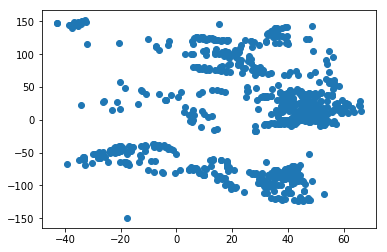

In [42]:
import matplotlib.pyplot as plt


res = %sql SELECT latitude, longitude FROM largest_populations;

lat,lon = zip(*res)

plt.scatter(lat,lon)
plt.show()

### 2. In the second part your job is to work with JSON data from the magic schema. The schema is based on the game Magic: The gathering

##### A. Find all the cards that is made by Rob Alexander

I limit to 10 here

In [46]:
%sql SELECT data FROM cards WHERE data @> '{"artist":"Rob Alexander"}' LIMIT 10;

10 rows affected.


data
"{'id': '4a7bf234af44e07d9a159d4d89e96ce320919917', 'cmc': 6, 'name': 'Beacon of Immortality', 'text': ""Double target player's life total. Shuffle Beacon of Immortality into its owner's library."", 'type': 'Instant', 'types': ['Instant'], 'artist': 'Rob Alexander', 'colors': ['White'], 'flavor': 'The cave floods with light. A thousand rays shine forth and meld into one.', 'layout': 'normal', 'number': '10', 'rarity': 'Rare', 'manaCost': '{5}{W}', 'imageName': 'beacon of immortality', 'mciNumber': '10', 'multiverseid': 130553, 'colorIdentity': ['W']}"
"{'id': '9cea331c080c3bbc7987c6560f65e39e9d1ed34f', 'cmc': 5, 'name': 'Kavu Climber', 'text': 'When Kavu Climber enters the battlefield, draw a card.', 'type': 'Creature — Kavu', 'power': '3', 'types': ['Creature'], 'artist': 'Rob Alexander', 'colors': ['Green'], 'flavor': '""There was a crack of branches, a rustle of leaves, then a tremendous roar. Our party had no chance as death descended from above.""\n—Taseen, elvish bard', 'layout': 'normal', 'number': '273', 'rarity': 'Common', 'manaCost': '{3}{G}{G}', 'subtypes': ['Kavu'], 'imageName': 'kavu climber', 'mciNumber': '273', 'toughness': '3', 'multiverseid': 129511, 'colorIdentity': ['G']}"
"{'id': '28cc7c79cca8939fd9661f7abfc6ca453715b75e', 'cmc': 0, 'name': 'Llanowar Wastes', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {G} to your mana pool. Llanowar Wastes deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '355', 'rarity': 'Rare', 'imageName': 'llanowar wastes', 'mciNumber': '355', 'multiverseid': 129627, 'colorIdentity': ['B', 'G']}"
"{'id': '7a90b7ba6197f8774ed99ecf75ac9abb3e0c0f20', 'cmc': 0, 'name': 'Shivan Reef', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {U} or {R} to your mana pool. Shivan Reef deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '357', 'rarity': 'Rare', 'imageName': 'shivan reef', 'mciNumber': '357', 'multiverseid': 129731, 'colorIdentity': ['U', 'R']}"
"{'id': '8d1035f151615c949d0645b70fe01d8ab4a3f796', 'cmc': 0, 'name': 'Sulfurous Springs', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {R} to your mana pool. Sulfurous Springs deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '359', 'rarity': 'Rare', 'imageName': 'sulfurous springs', 'mciNumber': '359', 'multiverseid': 129751, 'colorIdentity': ['B', 'R']}"
"{'id': 'c97103ab834aad9b3fb7d07c4fb563089f97fe87', 'cmc': 0, 'name': 'Treetop Village', 'text': ""Treetop Village enters the battlefield tapped.\n{T}: Add {G} to your mana pool.\n{1}{G}: Treetop Village becomes a 3/3 green Ape creature with trample until end of turn. It's still a land. (If it would assign enough damage to its blockers to destroy them, you may have it assign the rest of its damage to defending player or planeswalker.)"", 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '361', 'rarity': 'Uncommon', 'imageName': 'treetop village', 'mciNumber': '361', 'multiverseid': 106455, 'colorIdentity': ['G']}"
"{'id': '24a47bf9cb4596246501294e7127bf74e082bc1d', 'cmc': 0, 'name': 'Plains', 'type': 'Basic Land — Plains', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '364', 'rarity': 'Basic Land', 'subtypes': ['Plains'], 'imageName': 'plains1', 'watermark': 'White', 'supertypes': ['Basic'], 'variations': [129682, 129683, 129681], 'multiverseid': 129680, 'colorIdentity': ['W']}"
"{'id': 'be5e30798e4f8b9b6f6e6a8dd2e30bf86bb04b94', 'cmc': 0, 'name': 'Forest', 'type': 'Basic Land — Forest', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '382', 'rarity': 'Basic Land', 'subtypes': ['Forest'], 'imageName': 'forest3', 'watermark': 'Green', 'supertypes': ['Basic'], 'variations': [129559, 129562, 129560], 'multiverseid': 129561, 'colorIdentity': ['G']}"
"{'id': '4c3d9f2b708

##### B. Find all the cards that have the subtype "Human"

I limit to 10 here.


In [55]:
%sql SELECT data FROM cards WHERE data->>'subtypes' LIKE '%Human%' LIMIT 1;

1 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"


In [56]:
%sql SELECT data FROM cards WHERE data @> '{"subtypes":["Human"]}' LIMIT 1;


1 rows affected.


data
"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"


32 rows affected.


<Container object of 32 artists>

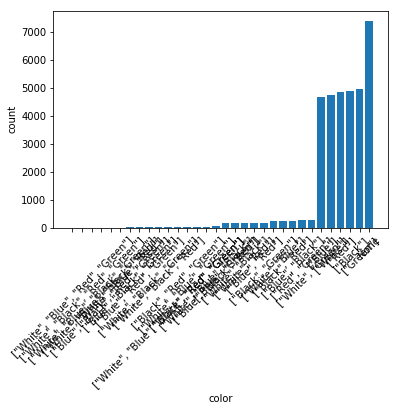

In [78]:
res = %sql SELECT data->>'colors' as color, count(*) FROM cards GROUP BY color order by count;
res.bar()

In [51]:
%sql SELECT data->>'colors' as color, count(*) FROM cards GROUP BY color order by count DESC LIMIT 60;

32 rows affected.


color,count
None,7391
"[""Green""]",4977
"[""Black""]",4877
"[""Red""]",4858
"[""White""]",4755
"[""Blue""]",4680
"[""White"", ""Green""]",276
"[""Red"", ""Green""]",273
"[""Blue"", ""Black""]",260
"[""Black"", ""Red""]",258


##### C. Group all the cards based on the colour. Aggregate them by counting the number of cards per colour.


In [52]:
%%sql DROP VIEW IF EXISTS colors_cards; 
CREATE VIEW colors_cards AS SELECT jsonb_array_elements(data -> 'colors') AS color_type, count(*) FROM cards GROUP BY color_type ORDER BY count;
SELECT * FROM colors_cards;


Done.
Done.
5 rows affected.


color_type,count
Blue,5836
White,5920
Red,6054
Black,6067
Green,6162


5 rows affected.


<Container object of 5 artists>

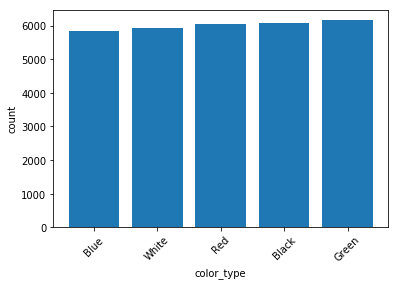

In [53]:
import matplotlib

res = %sql SELECT * FROM colors_cards ORDER BY count;
res.bar()

## No limit ...

In [ ]:
%sql SELECT name, longitude, latitude, point(latitude, longitude) <-> (SELECT max_point FROM maximum_population_geonames) as distance FROM  geonames order by distance;

In [ ]:
%sql SELECT name, longitude, latitude, geodistance(latitude, longitude,(SELECT latitude FROM maximum_population_geonames),(SELECT longitude FROM maximum_population_geonames)) as distance FROM  geonames order by distance LIMIT 10;

In [ ]:
%sql SELECT data FROM cards WHERE data @> '{"subtypes":["Human"]}';
